In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'densenet201', pretrained=False)
model.eval()

Using cache found in C:\Users\Otakuking/.cache\torch\hub\pytorch_vision_v0.9.0


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [3]:
batch_size = 16

transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='emotion5/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion5/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([16, 3, 224, 224])
out-size: torch.Size([3, 454, 1810])


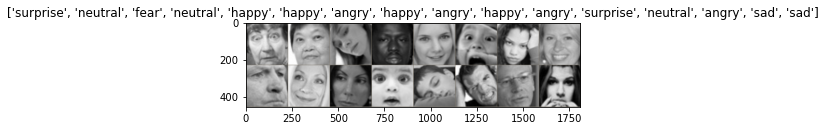

In [5]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [6]:
net = model
net = net.cuda() if device else net
net

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [8]:
n_epochs = 30
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'Densenet201_lr0.0001_adam_batch16_epoch20_pretrainFalse.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/30], Step [0/1768], Loss: 7.0414
Epoch [1/30], Step [20/1768], Loss: 2.0977
Epoch [1/30], Step [40/1768], Loss: 1.6745
Epoch [1/30], Step [60/1768], Loss: 2.0573
Epoch [1/30], Step [80/1768], Loss: 1.8153
Epoch [1/30], Step [100/1768], Loss: 1.9394
Epoch [1/30], Step [120/1768], Loss: 1.9932
Epoch [1/30], Step [140/1768], Loss: 2.0870
Epoch [1/30], Step [160/1768], Loss: 1.7844
Epoch [1/30], Step [180/1768], Loss: 1.7710
Epoch [1/30], Step [200/1768], Loss: 1.8319
Epoch [1/30], Step [220/1768], Loss: 1.8947
Epoch [1/30], Step [240/1768], Loss: 1.6302
Epoch [1/30], Step [260/1768], Loss: 1.7019
Epoch [1/30], Step [280/1768], Loss: 1.7486
Epoch [1/30], Step [300/1768], Loss: 1.8344
Epoch [1/30], Step [320/1768], Loss: 1.9139
Epoch [1/30], Step [340/1768], Loss: 2.0084
Epoch [1/30], Step [360/1768], Loss: 1.7885
Epoch [1/30], Step [380/1768], Loss: 1.7040
Epoch [1/30], Step [400/1768], Loss: 1.6336
Epoch [1/30], Step [420/1768], Loss: 1.6883
Epoch [1/30], Step [440/1768]

Epoch [3/30], Step [20/1768], Loss: 1.4561
Epoch [3/30], Step [40/1768], Loss: 1.1010
Epoch [3/30], Step [60/1768], Loss: 1.6596
Epoch [3/30], Step [80/1768], Loss: 1.1245
Epoch [3/30], Step [100/1768], Loss: 1.3323
Epoch [3/30], Step [120/1768], Loss: 0.9856
Epoch [3/30], Step [140/1768], Loss: 1.4360
Epoch [3/30], Step [160/1768], Loss: 0.9885
Epoch [3/30], Step [180/1768], Loss: 0.9468
Epoch [3/30], Step [200/1768], Loss: 0.8896
Epoch [3/30], Step [220/1768], Loss: 1.0702
Epoch [3/30], Step [240/1768], Loss: 1.0628
Epoch [3/30], Step [260/1768], Loss: 1.6013
Epoch [3/30], Step [280/1768], Loss: 0.9835
Epoch [3/30], Step [300/1768], Loss: 1.2505
Epoch [3/30], Step [320/1768], Loss: 1.2074
Epoch [3/30], Step [340/1768], Loss: 1.3507
Epoch [3/30], Step [360/1768], Loss: 1.4662
Epoch [3/30], Step [380/1768], Loss: 1.0907
Epoch [3/30], Step [400/1768], Loss: 0.8645
Epoch [3/30], Step [420/1768], Loss: 1.5407
Epoch [3/30], Step [440/1768], Loss: 1.3103
Epoch [3/30], Step [460/1768], Loss:

Epoch [5/30], Step [40/1768], Loss: 1.0476
Epoch [5/30], Step [60/1768], Loss: 0.6469
Epoch [5/30], Step [80/1768], Loss: 0.5716
Epoch [5/30], Step [100/1768], Loss: 1.1600
Epoch [5/30], Step [120/1768], Loss: 0.8415
Epoch [5/30], Step [140/1768], Loss: 0.9958
Epoch [5/30], Step [160/1768], Loss: 1.0164
Epoch [5/30], Step [180/1768], Loss: 0.6025
Epoch [5/30], Step [200/1768], Loss: 1.2073
Epoch [5/30], Step [220/1768], Loss: 1.0813
Epoch [5/30], Step [240/1768], Loss: 1.0178
Epoch [5/30], Step [260/1768], Loss: 0.7131
Epoch [5/30], Step [280/1768], Loss: 0.5832
Epoch [5/30], Step [300/1768], Loss: 0.8813
Epoch [5/30], Step [320/1768], Loss: 1.1810
Epoch [5/30], Step [340/1768], Loss: 1.1660
Epoch [5/30], Step [360/1768], Loss: 0.7403
Epoch [5/30], Step [380/1768], Loss: 0.8481
Epoch [5/30], Step [400/1768], Loss: 0.9461
Epoch [5/30], Step [420/1768], Loss: 0.9679
Epoch [5/30], Step [440/1768], Loss: 0.9375
Epoch [5/30], Step [460/1768], Loss: 0.7557
Epoch [5/30], Step [480/1768], Loss

Epoch [7/30], Step [60/1768], Loss: 0.8221
Epoch [7/30], Step [80/1768], Loss: 1.1237
Epoch [7/30], Step [100/1768], Loss: 0.4040
Epoch [7/30], Step [120/1768], Loss: 0.6512
Epoch [7/30], Step [140/1768], Loss: 0.5566
Epoch [7/30], Step [160/1768], Loss: 0.6538
Epoch [7/30], Step [180/1768], Loss: 0.7976
Epoch [7/30], Step [200/1768], Loss: 0.6308
Epoch [7/30], Step [220/1768], Loss: 0.3485
Epoch [7/30], Step [240/1768], Loss: 1.0732
Epoch [7/30], Step [260/1768], Loss: 0.8117
Epoch [7/30], Step [280/1768], Loss: 0.5735
Epoch [7/30], Step [300/1768], Loss: 0.7568
Epoch [7/30], Step [320/1768], Loss: 0.8460
Epoch [7/30], Step [340/1768], Loss: 0.5519
Epoch [7/30], Step [360/1768], Loss: 0.6612
Epoch [7/30], Step [380/1768], Loss: 1.4495
Epoch [7/30], Step [400/1768], Loss: 0.5886
Epoch [7/30], Step [420/1768], Loss: 0.8908
Epoch [7/30], Step [440/1768], Loss: 0.5725
Epoch [7/30], Step [460/1768], Loss: 0.7674
Epoch [7/30], Step [480/1768], Loss: 0.7665
Epoch [7/30], Step [500/1768], Los

Epoch [9/30], Step [120/1768], Loss: 0.4138
Epoch [9/30], Step [140/1768], Loss: 0.5162
Epoch [9/30], Step [160/1768], Loss: 0.5354
Epoch [9/30], Step [180/1768], Loss: 0.4336
Epoch [9/30], Step [200/1768], Loss: 0.1749
Epoch [9/30], Step [220/1768], Loss: 0.3160
Epoch [9/30], Step [240/1768], Loss: 0.1890
Epoch [9/30], Step [260/1768], Loss: 0.5822
Epoch [9/30], Step [280/1768], Loss: 0.5461
Epoch [9/30], Step [300/1768], Loss: 0.6508
Epoch [9/30], Step [320/1768], Loss: 0.4742
Epoch [9/30], Step [340/1768], Loss: 0.7607
Epoch [9/30], Step [360/1768], Loss: 0.2684
Epoch [9/30], Step [380/1768], Loss: 0.6949
Epoch [9/30], Step [400/1768], Loss: 0.4200
Epoch [9/30], Step [420/1768], Loss: 0.4490
Epoch [9/30], Step [440/1768], Loss: 0.4912
Epoch [9/30], Step [460/1768], Loss: 0.4921
Epoch [9/30], Step [480/1768], Loss: 0.6625
Epoch [9/30], Step [500/1768], Loss: 0.6908
Epoch [9/30], Step [520/1768], Loss: 0.6297
Epoch [9/30], Step [540/1768], Loss: 0.3182
Epoch [9/30], Step [560/1768], L

Epoch [11/30], Step [120/1768], Loss: 0.3336
Epoch [11/30], Step [140/1768], Loss: 0.4261
Epoch [11/30], Step [160/1768], Loss: 0.3023
Epoch [11/30], Step [180/1768], Loss: 0.2564
Epoch [11/30], Step [200/1768], Loss: 0.2653
Epoch [11/30], Step [220/1768], Loss: 0.3581
Epoch [11/30], Step [240/1768], Loss: 0.1055
Epoch [11/30], Step [260/1768], Loss: 0.3009
Epoch [11/30], Step [280/1768], Loss: 0.2316
Epoch [11/30], Step [300/1768], Loss: 0.2171
Epoch [11/30], Step [320/1768], Loss: 0.0528
Epoch [11/30], Step [340/1768], Loss: 0.1734
Epoch [11/30], Step [360/1768], Loss: 0.1332
Epoch [11/30], Step [380/1768], Loss: 0.4983
Epoch [11/30], Step [400/1768], Loss: 0.3103
Epoch [11/30], Step [420/1768], Loss: 0.2946
Epoch [11/30], Step [440/1768], Loss: 0.0423
Epoch [11/30], Step [460/1768], Loss: 0.1897
Epoch [11/30], Step [480/1768], Loss: 0.2888
Epoch [11/30], Step [500/1768], Loss: 0.2753
Epoch [11/30], Step [520/1768], Loss: 0.0686
Epoch [11/30], Step [540/1768], Loss: 0.1155
Epoch [11/

Epoch [13/30], Step [100/1768], Loss: 0.0652
Epoch [13/30], Step [120/1768], Loss: 0.1032
Epoch [13/30], Step [140/1768], Loss: 0.1908
Epoch [13/30], Step [160/1768], Loss: 0.1056
Epoch [13/30], Step [180/1768], Loss: 0.0880
Epoch [13/30], Step [200/1768], Loss: 0.2382
Epoch [13/30], Step [220/1768], Loss: 0.1959
Epoch [13/30], Step [240/1768], Loss: 0.3120
Epoch [13/30], Step [260/1768], Loss: 0.3255
Epoch [13/30], Step [280/1768], Loss: 0.0330
Epoch [13/30], Step [300/1768], Loss: 0.0286
Epoch [13/30], Step [320/1768], Loss: 0.3500
Epoch [13/30], Step [340/1768], Loss: 0.3433
Epoch [13/30], Step [360/1768], Loss: 0.0425
Epoch [13/30], Step [380/1768], Loss: 0.2841
Epoch [13/30], Step [400/1768], Loss: 0.2496
Epoch [13/30], Step [420/1768], Loss: 0.1013
Epoch [13/30], Step [440/1768], Loss: 0.1073
Epoch [13/30], Step [460/1768], Loss: 0.3982
Epoch [13/30], Step [480/1768], Loss: 0.1692
Epoch [13/30], Step [500/1768], Loss: 0.1298
Epoch [13/30], Step [520/1768], Loss: 0.3039
Epoch [13/

Epoch [15/30], Step [80/1768], Loss: 0.0164
Epoch [15/30], Step [100/1768], Loss: 0.0792
Epoch [15/30], Step [120/1768], Loss: 0.0761
Epoch [15/30], Step [140/1768], Loss: 0.3918
Epoch [15/30], Step [160/1768], Loss: 0.0147
Epoch [15/30], Step [180/1768], Loss: 0.0276
Epoch [15/30], Step [200/1768], Loss: 0.0681
Epoch [15/30], Step [220/1768], Loss: 0.0122
Epoch [15/30], Step [240/1768], Loss: 0.1470
Epoch [15/30], Step [260/1768], Loss: 0.2424
Epoch [15/30], Step [280/1768], Loss: 0.1048
Epoch [15/30], Step [300/1768], Loss: 0.0683
Epoch [15/30], Step [320/1768], Loss: 0.0267
Epoch [15/30], Step [340/1768], Loss: 0.2862
Epoch [15/30], Step [360/1768], Loss: 0.0427
Epoch [15/30], Step [380/1768], Loss: 0.1203
Epoch [15/30], Step [400/1768], Loss: 0.4120
Epoch [15/30], Step [420/1768], Loss: 0.2290
Epoch [15/30], Step [440/1768], Loss: 0.3973
Epoch [15/30], Step [460/1768], Loss: 0.1284
Epoch [15/30], Step [480/1768], Loss: 0.2853
Epoch [15/30], Step [500/1768], Loss: 0.1614
Epoch [15/3

Epoch [17/30], Step [60/1768], Loss: 0.0447
Epoch [17/30], Step [80/1768], Loss: 0.0165
Epoch [17/30], Step [100/1768], Loss: 0.0298
Epoch [17/30], Step [120/1768], Loss: 0.5272
Epoch [17/30], Step [140/1768], Loss: 0.0699
Epoch [17/30], Step [160/1768], Loss: 0.0561
Epoch [17/30], Step [180/1768], Loss: 0.1595
Epoch [17/30], Step [200/1768], Loss: 0.2647
Epoch [17/30], Step [220/1768], Loss: 0.0334
Epoch [17/30], Step [240/1768], Loss: 0.1679
Epoch [17/30], Step [260/1768], Loss: 0.2465
Epoch [17/30], Step [280/1768], Loss: 0.0940
Epoch [17/30], Step [300/1768], Loss: 0.4521
Epoch [17/30], Step [320/1768], Loss: 0.0602
Epoch [17/30], Step [340/1768], Loss: 0.1823
Epoch [17/30], Step [360/1768], Loss: 0.1601
Epoch [17/30], Step [380/1768], Loss: 0.1780
Epoch [17/30], Step [400/1768], Loss: 0.2087
Epoch [17/30], Step [420/1768], Loss: 0.1015
Epoch [17/30], Step [440/1768], Loss: 0.0109
Epoch [17/30], Step [460/1768], Loss: 0.3362
Epoch [17/30], Step [480/1768], Loss: 0.2959
Epoch [17/30

Epoch [19/30], Step [40/1768], Loss: 0.0626
Epoch [19/30], Step [60/1768], Loss: 0.1219
Epoch [19/30], Step [80/1768], Loss: 0.3155
Epoch [19/30], Step [100/1768], Loss: 0.1483
Epoch [19/30], Step [120/1768], Loss: 0.0489
Epoch [19/30], Step [140/1768], Loss: 0.0840
Epoch [19/30], Step [160/1768], Loss: 0.0290
Epoch [19/30], Step [180/1768], Loss: 0.1104
Epoch [19/30], Step [200/1768], Loss: 0.0359
Epoch [19/30], Step [220/1768], Loss: 0.3365
Epoch [19/30], Step [240/1768], Loss: 0.2403
Epoch [19/30], Step [260/1768], Loss: 0.0685
Epoch [19/30], Step [280/1768], Loss: 0.0665
Epoch [19/30], Step [300/1768], Loss: 0.1196
Epoch [19/30], Step [320/1768], Loss: 0.4488
Epoch [19/30], Step [340/1768], Loss: 0.0623
Epoch [19/30], Step [360/1768], Loss: 0.0739
Epoch [19/30], Step [380/1768], Loss: 0.1623
Epoch [19/30], Step [400/1768], Loss: 0.0053
Epoch [19/30], Step [420/1768], Loss: 0.0422
Epoch [19/30], Step [440/1768], Loss: 0.0515
Epoch [19/30], Step [460/1768], Loss: 0.0273
Epoch [19/30]

Epoch [21/30], Step [20/1768], Loss: 0.0376
Epoch [21/30], Step [40/1768], Loss: 0.2150
Epoch [21/30], Step [60/1768], Loss: 0.1342
Epoch [21/30], Step [80/1768], Loss: 0.1057
Epoch [21/30], Step [100/1768], Loss: 0.1130
Epoch [21/30], Step [120/1768], Loss: 0.2264
Epoch [21/30], Step [140/1768], Loss: 0.0814
Epoch [21/30], Step [160/1768], Loss: 0.1142
Epoch [21/30], Step [180/1768], Loss: 0.0614
Epoch [21/30], Step [200/1768], Loss: 0.1267
Epoch [21/30], Step [220/1768], Loss: 0.0253
Epoch [21/30], Step [240/1768], Loss: 0.0324
Epoch [21/30], Step [260/1768], Loss: 0.0539
Epoch [21/30], Step [280/1768], Loss: 0.0378
Epoch [21/30], Step [300/1768], Loss: 0.1400
Epoch [21/30], Step [320/1768], Loss: 0.0130
Epoch [21/30], Step [340/1768], Loss: 0.0523
Epoch [21/30], Step [360/1768], Loss: 0.0329
Epoch [21/30], Step [380/1768], Loss: 0.0289
Epoch [21/30], Step [400/1768], Loss: 0.0278
Epoch [21/30], Step [420/1768], Loss: 0.0044
Epoch [21/30], Step [440/1768], Loss: 0.0388
Epoch [21/30],

Epoch [23/30], Step [0/1768], Loss: 0.1613
Epoch [23/30], Step [20/1768], Loss: 0.2406
Epoch [23/30], Step [40/1768], Loss: 0.4544
Epoch [23/30], Step [60/1768], Loss: 0.0259
Epoch [23/30], Step [80/1768], Loss: 0.0451
Epoch [23/30], Step [100/1768], Loss: 0.0039
Epoch [23/30], Step [120/1768], Loss: 0.1325
Epoch [23/30], Step [140/1768], Loss: 0.0099
Epoch [23/30], Step [160/1768], Loss: 0.1376
Epoch [23/30], Step [180/1768], Loss: 0.0557
Epoch [23/30], Step [200/1768], Loss: 0.0511
Epoch [23/30], Step [220/1768], Loss: 0.1444
Epoch [23/30], Step [240/1768], Loss: 0.0186
Epoch [23/30], Step [260/1768], Loss: 0.2791
Epoch [23/30], Step [280/1768], Loss: 0.3116
Epoch [23/30], Step [300/1768], Loss: 0.2017
Epoch [23/30], Step [320/1768], Loss: 0.1749
Epoch [23/30], Step [340/1768], Loss: 0.1008
Epoch [23/30], Step [360/1768], Loss: 0.1111
Epoch [23/30], Step [380/1768], Loss: 0.0057
Epoch [23/30], Step [400/1768], Loss: 0.0180
Epoch [23/30], Step [420/1768], Loss: 0.0077
Epoch [23/30], S

validation loss: 1.4971, validation acc: 62.4593

Epoch 25

Epoch [25/30], Step [0/1768], Loss: 0.0223
Epoch [25/30], Step [20/1768], Loss: 0.0206
Epoch [25/30], Step [40/1768], Loss: 0.0483
Epoch [25/30], Step [60/1768], Loss: 0.0217
Epoch [25/30], Step [80/1768], Loss: 0.0047
Epoch [25/30], Step [100/1768], Loss: 0.0416
Epoch [25/30], Step [120/1768], Loss: 0.0608
Epoch [25/30], Step [140/1768], Loss: 0.0875
Epoch [25/30], Step [160/1768], Loss: 0.0122
Epoch [25/30], Step [180/1768], Loss: 0.0457
Epoch [25/30], Step [200/1768], Loss: 0.2020
Epoch [25/30], Step [220/1768], Loss: 0.0484
Epoch [25/30], Step [240/1768], Loss: 0.0350
Epoch [25/30], Step [260/1768], Loss: 0.2237
Epoch [25/30], Step [280/1768], Loss: 0.1531
Epoch [25/30], Step [300/1768], Loss: 0.0627
Epoch [25/30], Step [320/1768], Loss: 0.0588
Epoch [25/30], Step [340/1768], Loss: 0.1396
Epoch [25/30], Step [360/1768], Loss: 0.0578
Epoch [25/30], Step [380/1768], Loss: 0.0538
Epoch [25/30], Step [400/1768], Loss: 0.0636
E


train-loss: 0.4606, train-acc: 96.6045
validation loss: 1.5326, validation acc: 64.4970

Epoch 27

Epoch [27/30], Step [0/1768], Loss: 0.1693
Epoch [27/30], Step [20/1768], Loss: 0.0064
Epoch [27/30], Step [40/1768], Loss: 0.1127
Epoch [27/30], Step [60/1768], Loss: 0.0300
Epoch [27/30], Step [80/1768], Loss: 0.0590
Epoch [27/30], Step [100/1768], Loss: 0.0040
Epoch [27/30], Step [120/1768], Loss: 0.0060
Epoch [27/30], Step [140/1768], Loss: 0.1044
Epoch [27/30], Step [160/1768], Loss: 0.2838
Epoch [27/30], Step [180/1768], Loss: 0.2468
Epoch [27/30], Step [200/1768], Loss: 0.0188
Epoch [27/30], Step [220/1768], Loss: 0.4199
Epoch [27/30], Step [240/1768], Loss: 0.0187
Epoch [27/30], Step [260/1768], Loss: 0.1071
Epoch [27/30], Step [280/1768], Loss: 0.0039
Epoch [27/30], Step [300/1768], Loss: 0.0048
Epoch [27/30], Step [320/1768], Loss: 0.0024
Epoch [27/30], Step [340/1768], Loss: 0.0109
Epoch [27/30], Step [360/1768], Loss: 0.0159
Epoch [27/30], Step [380/1768], Loss: 0.0352
Epoch 

Epoch [28/30], Step [1760/1768], Loss: 0.3294

train-loss: 0.4343, train-acc: 96.9370
validation loss: 1.5625, validation acc: 64.5394

Epoch 29

Epoch [29/30], Step [0/1768], Loss: 0.0574
Epoch [29/30], Step [20/1768], Loss: 0.0774
Epoch [29/30], Step [40/1768], Loss: 0.0087
Epoch [29/30], Step [60/1768], Loss: 0.0153
Epoch [29/30], Step [80/1768], Loss: 0.0365
Epoch [29/30], Step [100/1768], Loss: 0.0259
Epoch [29/30], Step [120/1768], Loss: 0.0783
Epoch [29/30], Step [140/1768], Loss: 0.0112
Epoch [29/30], Step [160/1768], Loss: 0.0074
Epoch [29/30], Step [180/1768], Loss: 0.0140
Epoch [29/30], Step [200/1768], Loss: 0.0039
Epoch [29/30], Step [220/1768], Loss: 0.0227
Epoch [29/30], Step [240/1768], Loss: 0.0182
Epoch [29/30], Step [260/1768], Loss: 0.0387
Epoch [29/30], Step [280/1768], Loss: 0.0015
Epoch [29/30], Step [300/1768], Loss: 0.1818
Epoch [29/30], Step [320/1768], Loss: 0.0054
Epoch [29/30], Step [340/1768], Loss: 0.0143
Epoch [29/30], Step [360/1768], Loss: 0.0634
Epoch

Epoch [30/30], Step [1740/1768], Loss: 0.2368
Epoch [30/30], Step [1760/1768], Loss: 0.1354

train-loss: 0.4111, train-acc: 97.2164
validation loss: 1.5859, validation acc: 64.9498



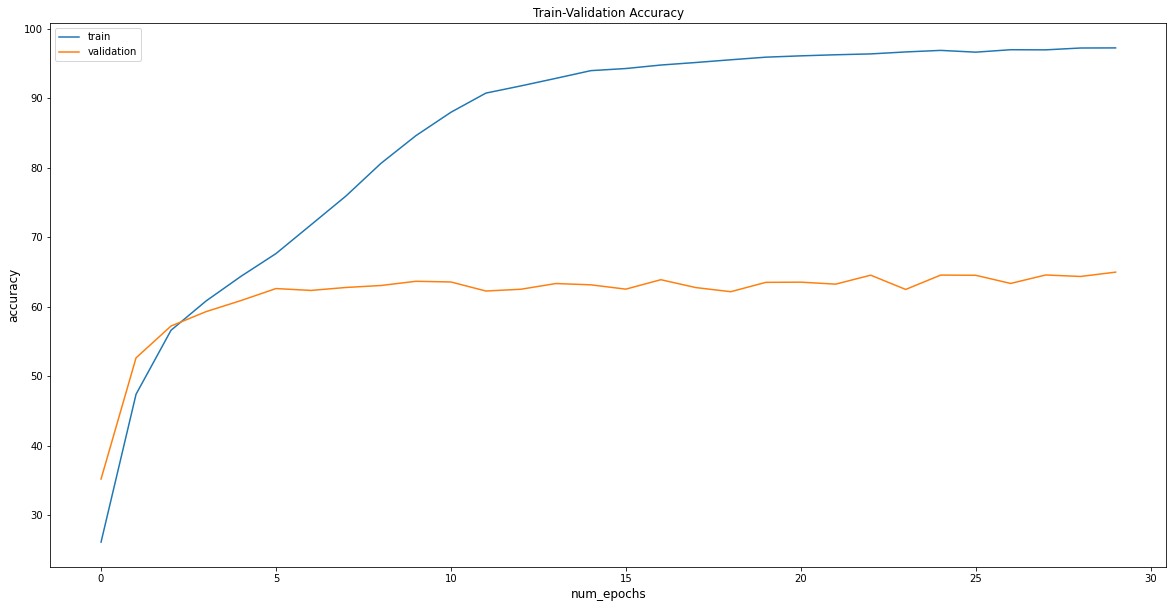

In [9]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

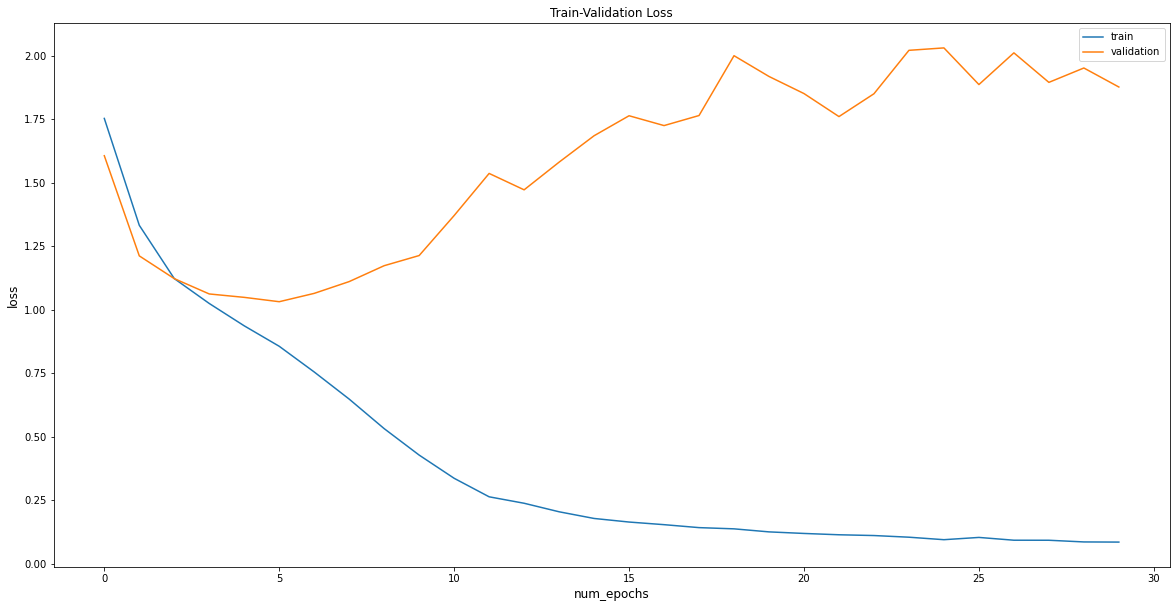

In [10]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Loss")
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

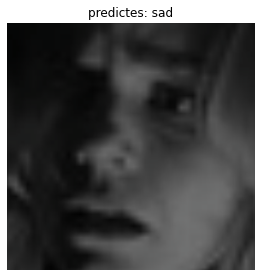

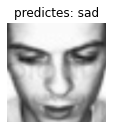

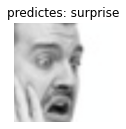

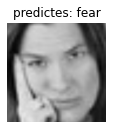

In [11]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()